In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch
import torch.nn as nn
import numpy as np
import cv2
import torchvision as tv
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import pytorch_lightning as pl
import random
import glob

plt.rcParams['figure.figsize'] = [20, 10]
script_dir = os.path.dirname('__file__')
sys.path.append(os.path.join(script_dir, '..', 'src'))
from subset import Subset
import data_handler
import model
import experiment_builder


c:\Users\Lisa\miniconda3\envs\idp_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
seed = 15
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True

In [4]:

def color_constancy(image, p_power= 6, gamma = None):
    image = image.numpy()
        
    if gamma is not None:
        image = np.round(image * 255.0)
        image = image.astype('uint8')
        look_up_table = np.zeros((256,1), dtype='uint8')
        for i in range(256):
            look_up_table[i][0] = 255*pow(i/255, 1/gamma)
        image = cv2.LUT(image, look_up_table)
        image = image * (1/255.0)

    img = image.astype('float32')
    img_power = np.power(img, p_power)
    rgb_vec = np.power(np.mean(img_power, (1,2)), 1/p_power)
    rgb_norm = np.sqrt(np.sum(np.power(rgb_vec, 2.0)))
    rgb_vec = rgb_vec/rgb_norm
    rgb_vec = 1/(rgb_vec*np.sqrt(3))
    img = np.multiply(img, rgb_vec[:, None, None])
    np.where(image > 1, image, 1.0)
    return torch.from_numpy(img)

                                            

In [5]:
# load dataset untransformed 
root = root_path = os.path.expanduser("~/share-all/derma-data/")
original_whole_dataset = datasets.ImageFolder(os.path.join(root, "clean"), transforms.ToTensor())
preprocessed_whole_dataset = datasets.ImageFolder(os.path.join(root, "preprocessed"), transforms.Compose([transforms.ToTensor(), transforms.Lambda(color_constancy)]))
train_data = Subset(original_whole_dataset, np.random.permutation(len(original_whole_dataset)-1))

# define trainloader
train_loader = torch.utils.data.DataLoader(train_data,
                                                        batch_size=16,
                                                        num_workers=8,
                                                        drop_last=False,
                                                        timeout=30000,
                                                        pin_memory=True)
ckpt = max(glob.glob('../checkpoints/*.ckpt'), key=os.path.getctime)
weights = data_handler.compute_weights(preprocessed_whole_dataset, 1)

hparams = {
        "e": 100,
        "b": 32,
        "d": "preprocessed",
        "lr": 10e-3,
        "wd": None,
        "ws": 1,
        "m": None,
        "ex": "Testing latent space visualization",
        "t": None,
        "l": None,
        "osr": 1.5,
        "lrf": None
    }
experimentbuilder = experiment_builder.ExperimentBuilder(hparams, 8, weights)
layers = list(experimentbuilder.get_model().children())
convolution_layers = layers[:-1]
model = model.Classifier.load_from_checkpoint(ckpt, hparams=hparams, classifier= nn.Linear(
            layers[-1][1].in_features, 8),extractor= nn.Sequential(*convolution_layers), loss= nn.CrossEntropyLoss())


FileNotFoundError: [WinError 3] The system cannot find the path specified: '../checkpoints\\Classic weighted sampling with Normalization = [mean=[0.657, 0.548, 0.532], std=[0.204, 0.197, 0.208]] over preprocessed dataset-efficientnet_b0-bs=32-epoch=164-bs=32val_acc=0.31.ckpt'

In [10]:
def latent_space_visualization(model, train_loader):
    latent_points = np.array()
    it = iter(train_loader) 
    for i in range(4):
        batch = next(it)
        X, y = batch
        latent_variables = model.forward(X)
        np.append(latent_points, latent_variables)

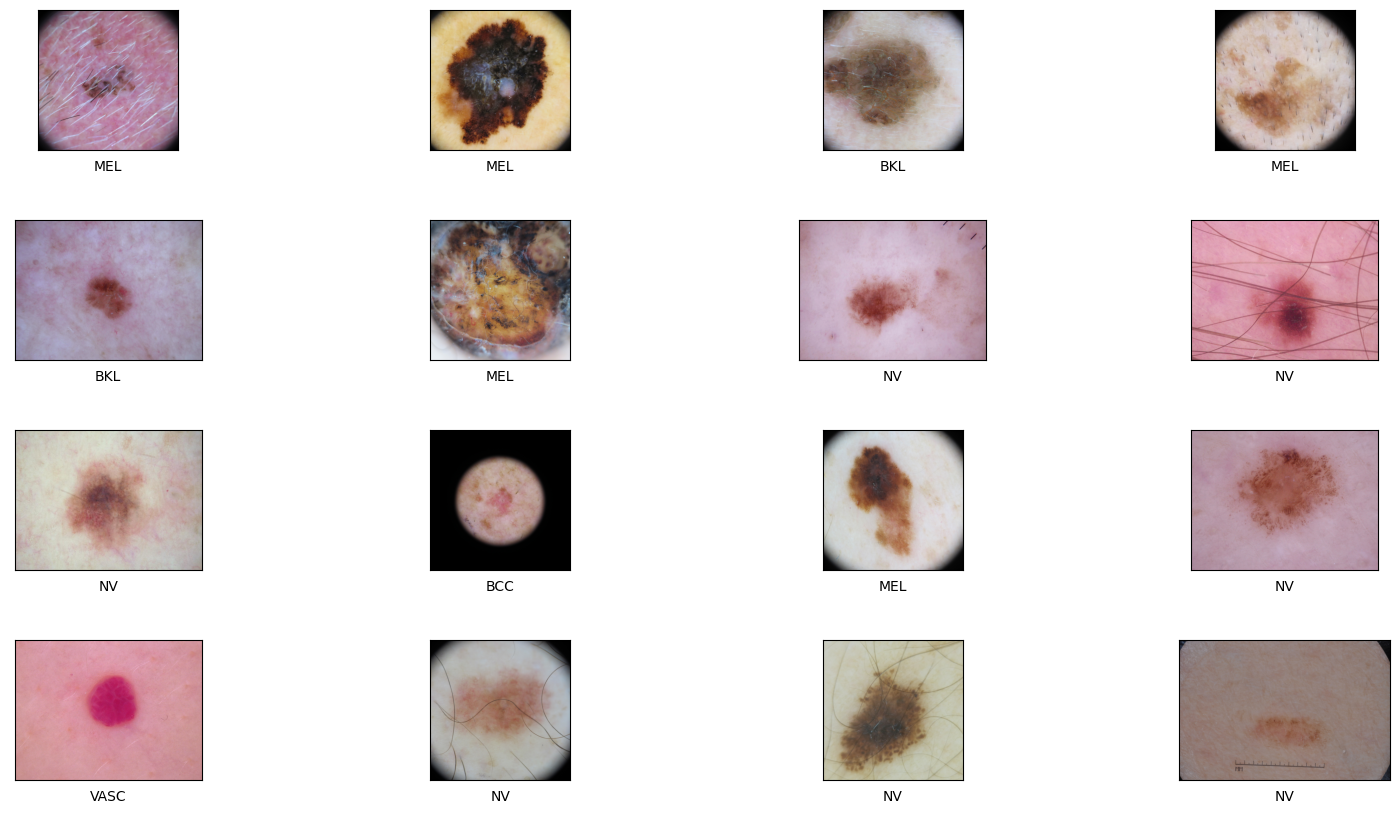

In [11]:
# Show 16 images:
f, ax = plt.subplots(4, 4)
f.subplots_adjust(hspace=0.5, wspace= 0.05)
for i in range(0, 4):
    for j in range(0, 4):
        ax[i, j].imshow(train_data[i * 4 + j][0].transpose(2,0).transpose(0,1).numpy())
        ax[i,j].yaxis.set_visible(False)
        # ax[i,j].xaxis.set_visible(False)
        ax[i,j].set_xlabel(train_data.idx_to_class[train_data[4*i + j][1]])
        ax[i,j].xaxis.set_ticklabels([])
        ax[i,j].xaxis.set_ticklabels([])
        ax[i,j].xaxis.set_ticks([])

In [37]:
# all basic transforms concluded by cropping to (224,224)
img_transforms = nn.Sequential(transforms.Resize((224,224)), transforms.RandomVerticalFlip(0.5), transforms.RandomHorizontalFlip(0.5), transforms.RandomRotation(degrees=(0, 180)))

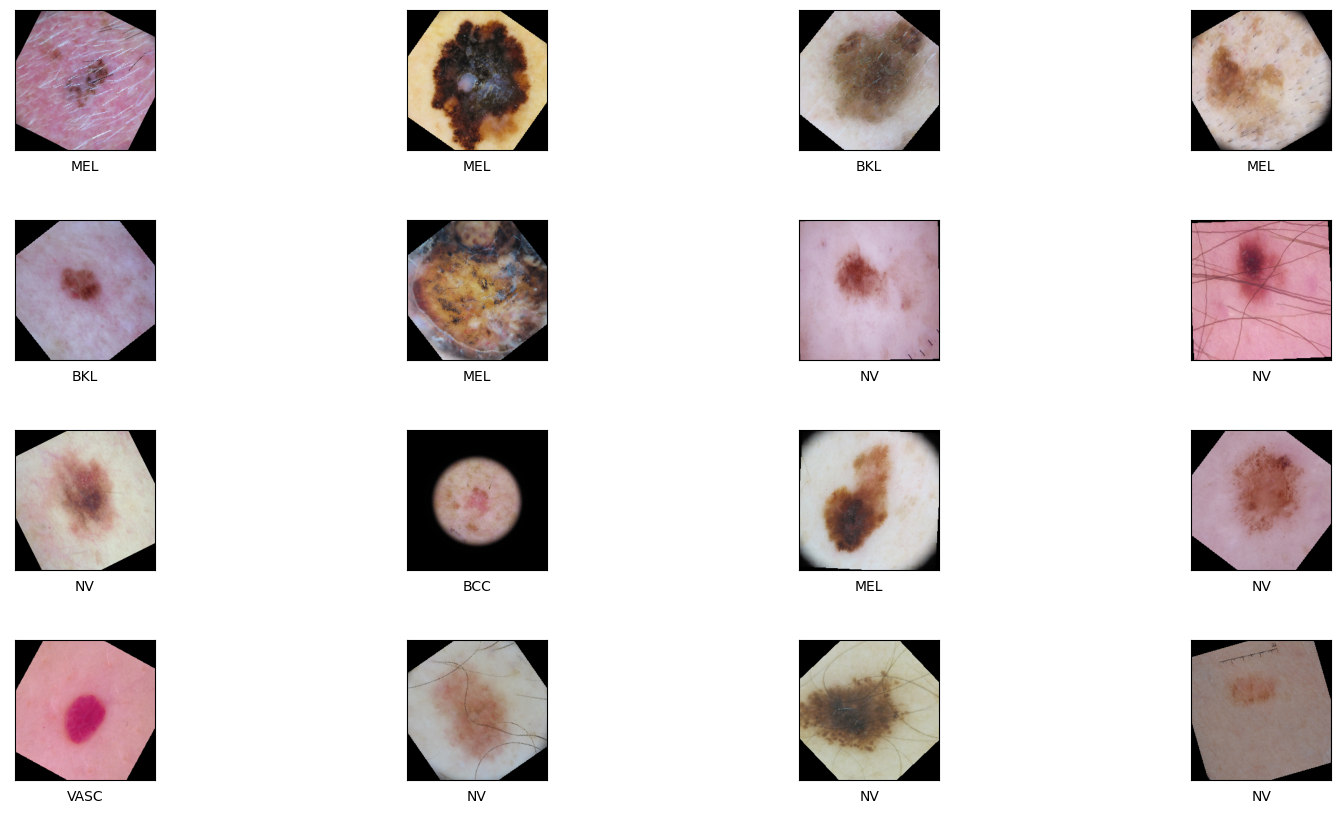

In [38]:
# Effect of using first rotations then cropping to size (224,224)
f, ax = plt.subplots(4, 4)
f.subplots_adjust(hspace=0.5, wspace= 0.05)
for i in range(0, 4):
    for j in range(0, 4):
        image_np = train_data[i * 4 + j][0].numpy()
        trf_img = img_transforms(torch.from_numpy(image_np))
        trf_img = trf_img.numpy()
        trf_img = np.transpose(trf_img,(1,2,0))
        ax[i, j].imshow(trf_img)
        ax[i,j].yaxis.set_visible(False)
        # ax[i,j].xaxis.set_visible(False)
        ax[i,j].set_xlabel(train_data.idx_to_class[train_data[4*i + j][1]])
        ax[i,j].xaxis.set_ticklabels([])
        ax[i,j].xaxis.set_ticklabels([])
        ax[i,j].xaxis.set_ticks([])

In [8]:
# all basic transforms in original sequence
original_transforms = nn.Sequential(transforms.Resize((224, 224)),transforms.RandomPerspective())

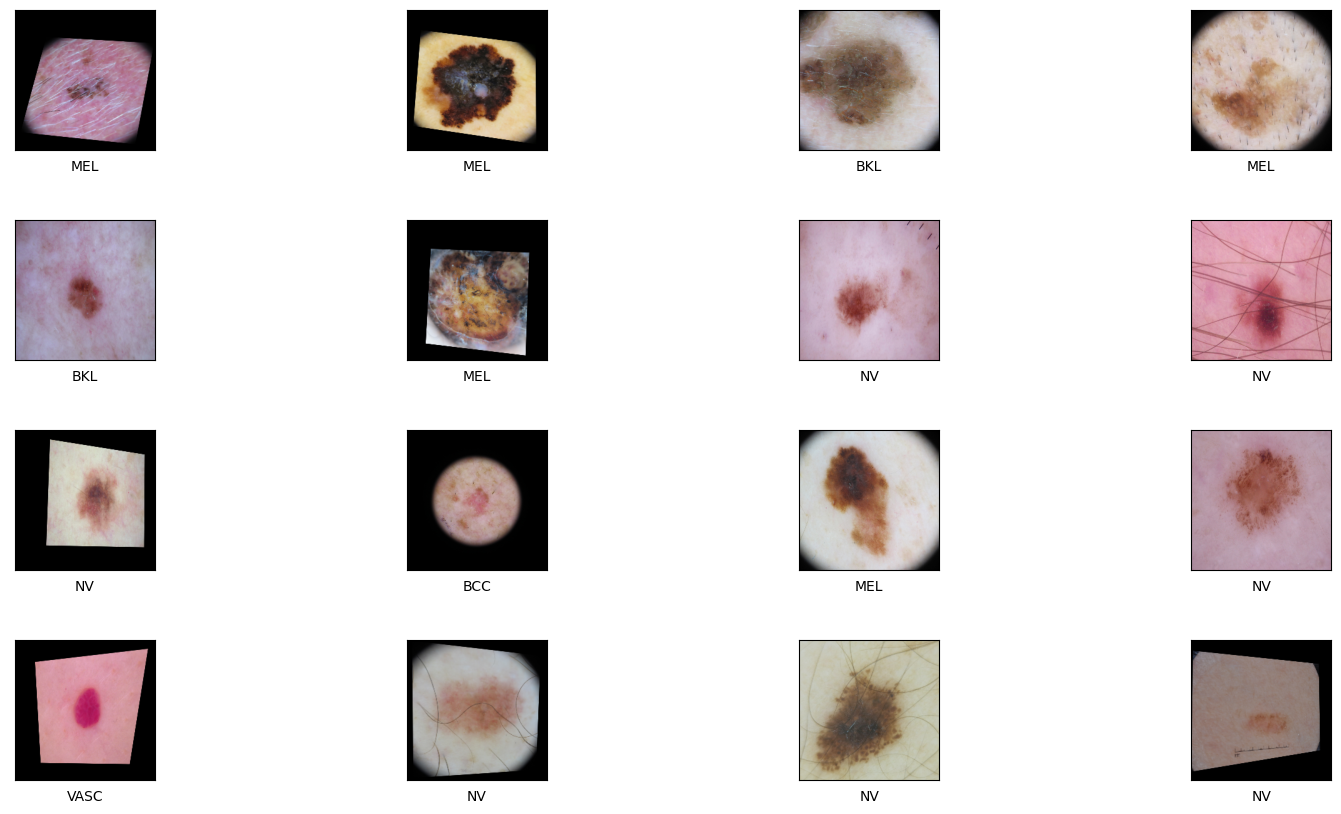

In [11]:
# Effect of using cropping to size (224,224) first then basic transformations
f, ax = plt.subplots(4, 4)
f.subplots_adjust(hspace=0.5, wspace= 0.05)
for i in range(0, 4):
    for j in range(0, 4):
        image_np = train_data[i * 4 + j][0].numpy()
        trf_img = original_transforms(torch.from_numpy(image_np))
        trf_img = trf_img.numpy()
        trf_img = np.transpose(trf_img,(1,2,0))
        ax[i, j].imshow(trf_img)
        ax[i,j].yaxis.set_visible(False)
        # ax[i,j].xaxis.set_visible(False)
        ax[i,j].set_xlabel(train_data.idx_to_class[train_data[4*i + j][1]])
        ax[i,j].xaxis.set_ticklabels([])
        ax[i,j].xaxis.set_ticklabels([])
        ax[i,j].xaxis.set_ticks([])

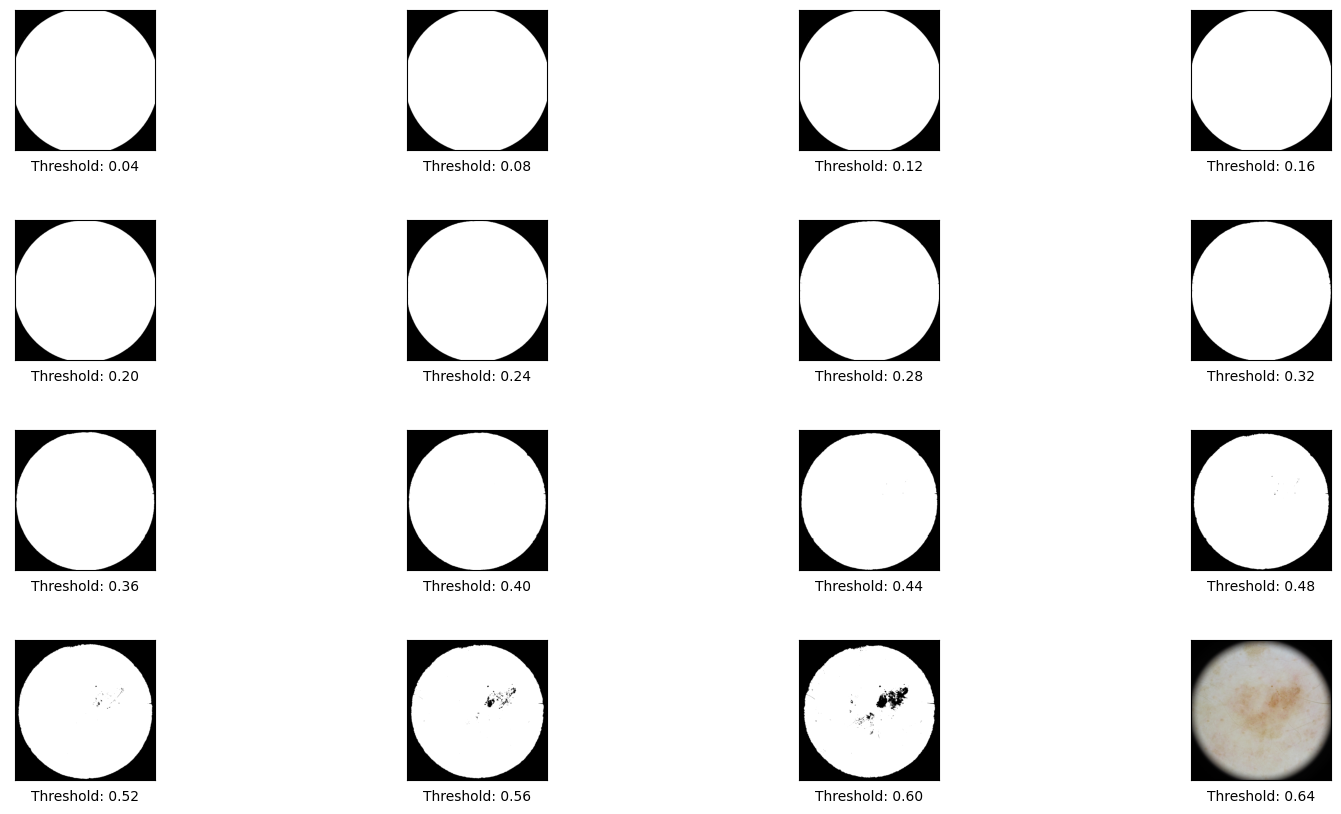

In [15]:
for k in range(0,100):
    # find first image with a black pixel
    if (train_data[k][0].min() < 0.005):
        f, ax = plt.subplots(4, 4)
        f.subplots_adjust(hspace=0.5, wspace= 0.05)
        for i in range(0, 4):
            for j in range(0, 4):
                # convert to black-white image via threshold
                threshold = 0.04 * (i * 4 + j) + 0.04
                grey_img = (torch.sum(train_data[k][0], dim=0) / 3)
                ax[i, j].imshow((1.0 * (grey_img >= threshold)).numpy(), cmap="gray")
                ax[i,j].yaxis.set_visible(False)
                # ax[i,j].xaxis.set_visible(False)
                ax[i,j].set_xlabel(f"Threshold: {threshold:.2f}")
                ax[i,j].xaxis.set_ticklabels([])
                ax[i,j].xaxis.set_ticklabels([])
                ax[i,j].xaxis.set_ticks([])
        break   # Search for the first image with a black border

plt.imshow(train_data[k][0].transpose(0,2).transpose(0,1).numpy(), cmap="gray")

In [16]:
edge = 0.01
images_with_black_edges = []
    

In [17]:
for k in range(3000):
    image = train_data[k][0]
    grey_img = (torch.sum(image, dim=0) / 3).numpy()
    label = train_data[k][1]
    has_black_edges = ((np.average(grey_img[0][:]) < edge) and (np.average(grey_img[-1][:]) < edge) and (np.average(grey_img[:][0]) < edge) and (np.average(grey_img[:][-1]) < edge))
    if(has_black_edges):
        images_with_black_edges.append((image, label))

In [ ]:
original_image = images_with_black_edges[0][0]
grey_img = (torch.sum(images_with_black_edges[0][0], dim=0) / 3).numpy()

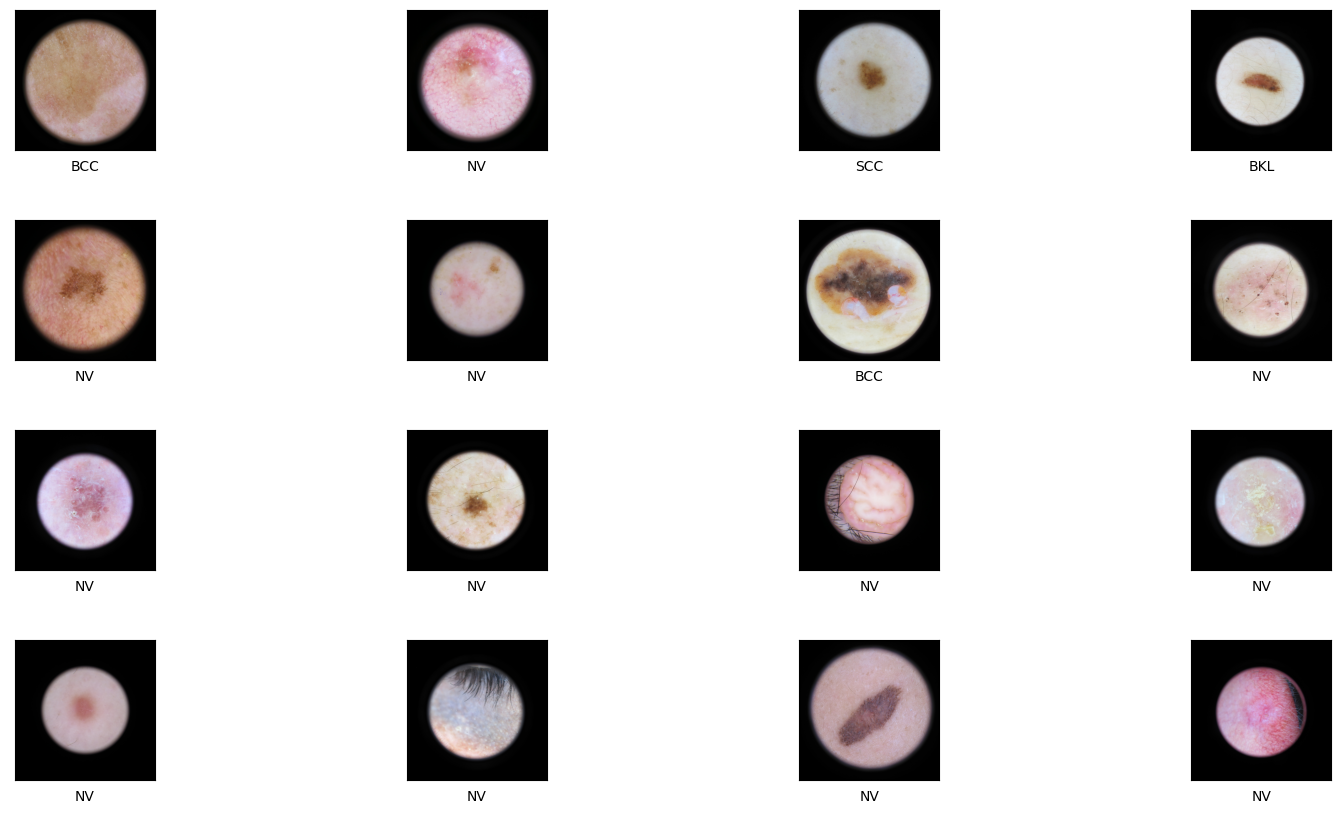

In [ ]:
# Testing filtering the images with black edges all around
f, ax = plt.subplots(4, 4)
f.subplots_adjust(hspace=0.5, wspace= 0.05)
for i in range(0, 4):
    for j in range(0, 4):
        image_np = images_with_black_edges[ i* 4 + j]
        trf_img = image_np.numpy()
        trf_img = np.transpose(trf_img,(1,2,0))
        ax[i, j].imshow(trf_img)
        ax[i,j].yaxis.set_visible(False)
        # ax[i,j].xaxis.set_visible(False)
        ax[i,j].set_xlabel(train_data.idx_to_class[train_data[4*i + j][1]])
        ax[i,j].xaxis.set_ticklabels([])
        ax[i,j].xaxis.set_ticklabels([])
        ax[i,j].xaxis.set_ticks([])

In [ ]:
def preprocess_image(image):
    blwh_img = (1.0 * (grey_img >= 0.4))
    cov_m = np.cov(blwh_img)
    box_idx = np.argwhere((cov_m) > 0.001)
    outer_points = np.argmax(box_idx, axis=0)
    height= np.abs(box_idx[outer_points[0],0] - box_idx[outer_points[0],1])
    width = np.abs(box_idx[outer_points[1],0] - box_idx[outer_points[1],1])
    total_pixels = image.shape[1]*image.shape[2]
    black_pixels_before = total_pixels - np.sum(blwh_img)
    cut_black_pixels = total_pixels - (width*height)
    return total_pixels, black_pixels_before, cut_black_pixels

In [ ]:
# Number of black pixels in images that are preprocessed (have black border)
total_black_pixels = 0
# Sum of black pixels cut from preprocessed (that had black border)
total_black_pixels_cut = 0
# Total number of pixels in images that are preprocessed (have black border)
total_pixels = 0
count = 0
# Filter out images with black edges

for k in range(len(original_whole_dataset)):
    if (k % 1000 == 0 & k> 0):
        print(f"Average percentage of black pixels cut: {(black_pixels_cut/total_black_pixels)*100}%", f"Average percentage of total pixels cut: {(black_pixels_cut/total_pixels)*100}%",f"Average percentage of black pixels in the image: {(total_black_pixels/total_pixels)*100}% ", k)
    image, label = original_whole_dataset[k]
    grey_img = (torch.sum(image, dim=0) / 3).numpy()
    has_black_edges = ((np.average(grey_img[0][:]) < edge) and (np.average(grey_img[-1][:]) < edge) and (np.average(grey_img[:][0]) < edge) and (np.average(grey_img[:][-1]) < edge))
    if(has_black_edges):
        count += 1
        image_pixels, black_pixels, black_pixels_cut = preprocess_image(image)
        total_pixels += image_pixels
        total_black_pixels += black_pixels
        total_black_pixels_cut += black_pixels_cut
print(f"Average percentage of black pixels cut: {(total_black_pixels_cut/total_black_pixels)*100}% of the images' black pixels were cut")
print(f"Average percentage of total pixels cut: {(total_black_pixels_cut/total_pixels)*100}% pixels were cut of the image")
print(f"Average percentage of black pixels in the image: {(total_black_pixels/total_pixels)*100}% of the image were black pixels in images with black borders")
print(f"Average percentage of images with black borders: {(count/len(original_whole_dataset))*100}% of the images in the dataset were images with black edges")

KeyboardInterrupt: 

In [ ]:
# Number of black pixels in images that are preprocessed (have black border)
per_channel_sum = torch.zeros(3)
# Sum of black pixels cut from preprocessed (that had black border)
per_channel_squared_sum = torch.zeros(3)
# Total number of pixels in images that are preprocessed (have black border)
total_pixels = 0
# per class count
per_class_total = torch.zeros(8)
# Filter out images with black edges
whole_dataset = preprocessed_whole_dataset
print(whole_dataset[0][1], whole_dataset[1000][1], whole_dataset[2000][1], whole_dataset[3000][1], whole_dataset[4000][1], whole_dataset[5000][1], whole_dataset[6000][1])

for k in range(len(whole_dataset)):
    """
    if (k == 500):
        print("I'm still standing")
        print(f"Per channel mean: {(per_channel_sum/total_pixels)}",f"Per channel variance: {(per_channel_squared_sum/total_pixels) - torch.pow((per_channel_sum/total_pixels),2)}", k)
        print(f"{per_class_total=}")
    if (((k % 1000) == 0) & (k > 0)):
        print(f"Per channel mean: {(per_channel_sum/total_pixels)}",f"Per channel variance: {(per_channel_squared_sum/total_pixels) - torch.pow((per_channel_sum/total_pixels),2)}", k)
        print(f"{per_class_total=}")
    """
    image, label = whole_dataset[k]
    per_class_total[label] += 1
    total_pixels += image.shape[1] * image.shape[2]
    per_channel_sum += torch.sum(image, axis=(1,2))
    per_channel_squared_sum += torch.sum(torch.pow(image,2), axis=(1,2))
per_channel_mean = (per_channel_sum/total_pixels)
per_channel_variance = (per_channel_squared_sum/total_pixels) - torch.pow(per_channel_mean,2)
per_channel_std = torch.sqrt(per_channel_variance)
print(f"Per channel mean: {per_channel_mean}")
print(f"Per channel variance: {per_channel_variance}")
print(f"Per channel standard deviation: {per_channel_std}")
print(f"Per class total:", per_class_total, "Per class percentages:", (per_class_total/len(whole_dataset)))

NameError: name 'preprocessed_whole_dataset' is not defined

In [ ]:
altered_images, black_areas_percentage = preprocess_images(images_with_black_edges)
f, ax = plt.subplots(4, 4)
f.subplots_adjust(hspace=0.5, wspace= 0.05)
for i in range(0, 4):
    for j in range(0, 4):
        image_np = altered_images[ i* 4 + j][0]
        trf_img = image_np.numpy()
        #print(trf_img.shape)
        trf_img = np.transpose(trf_img,(1,2,0))
        ax[i, j].imshow(trf_img)
        ax[i,j].yaxis.set_visible(False)
        # ax[i,j].xaxis.set_visible(False)
        ax[i,j].set_xlabel(train_data.idx_to_class[train_data[4*i + j][1]])
        ax[i,j].xaxis.set_ticklabels([])
        ax[i,j].xaxis.set_ticklabels([])
        ax[i,j].xaxis.set_ticks([])

NameError: name 'preprocess_images' is not defined

torch.Size([3, 1024, 1024])


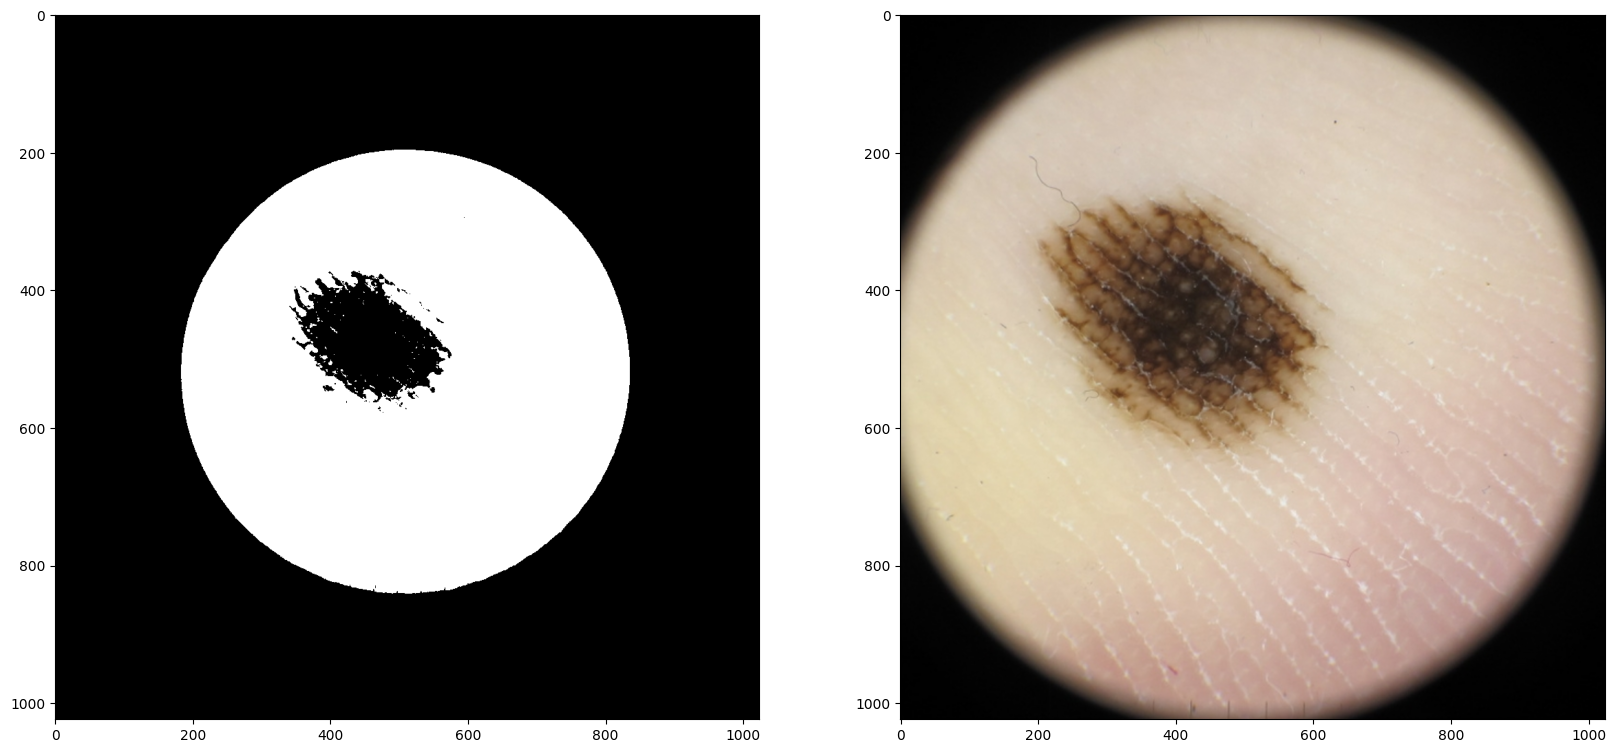

In [18]:

edge = 0.01
image = images_with_black_edges[0][0]
grey_img = (torch.sum(image, dim=0) / 3).numpy()
has_black_edges = ((np.average(grey_img[0,:]) < edge) and (np.average(grey_img[-1,:]) < edge) and (np.average(grey_img[:,0]) < edge) and (np.average(grey_img[:,-1]) < edge))
if(has_black_edges):
    blwh_img = (1.0 * (grey_img >= 0.4))
    cov_m = np.cov(blwh_img)
    box_idx = np.argwhere((cov_m) > 0.001)
    outer_points = np.argmax(box_idx, axis=0)
    height= np.abs(box_idx[outer_points[0],0] - box_idx[outer_points[0],1])
    width = np.abs(box_idx[outer_points[1],0] - box_idx[outer_points[1],1])
    sample = (tv.transforms.functional.resized_crop(image, top=box_idx[0,0], left=box_idx[0,1],height= height, width= width, size=grey_img.shape), label)
f, ax = plt.subplots(1, 2)
print(sample[0].shape)
#ax[0].imshow(np.transpose(image,(1,2,0)))
ax[0].imshow(blwh_img, cmap="gray")
ax[1].imshow(np.transpose(sample[0],(1,2,0)))

In [ ]:
def compute_weights(dataset, weight_scheme = 0):
    class_sample_count = np.unique(dataset.targets, return_counts=True)[1]
    weights = 1.0 / class_sample_count
    # no weight scheme used
    if(weight_scheme == 0):
        return None, None
    elif(weight_scheme == 2):
        weights_avg = np.avg(weights)
        weights = weights + weights_avg
        # Medically especially important classes BCC:1, MEL:4, NV:5 and SCC:6 recieve higher weights
    elif(weight_scheme == 3):
        weights = np.array([1,4,1,1,4,2,4,1])
    weights_per_sample = np.array([weights[t] for t in dataset.targets])
    return torch.from_numpy(weights).float(), torch.from_numpy(weights_per_sample).float()

: 

In [81]:
from PIL import Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 233, 204])


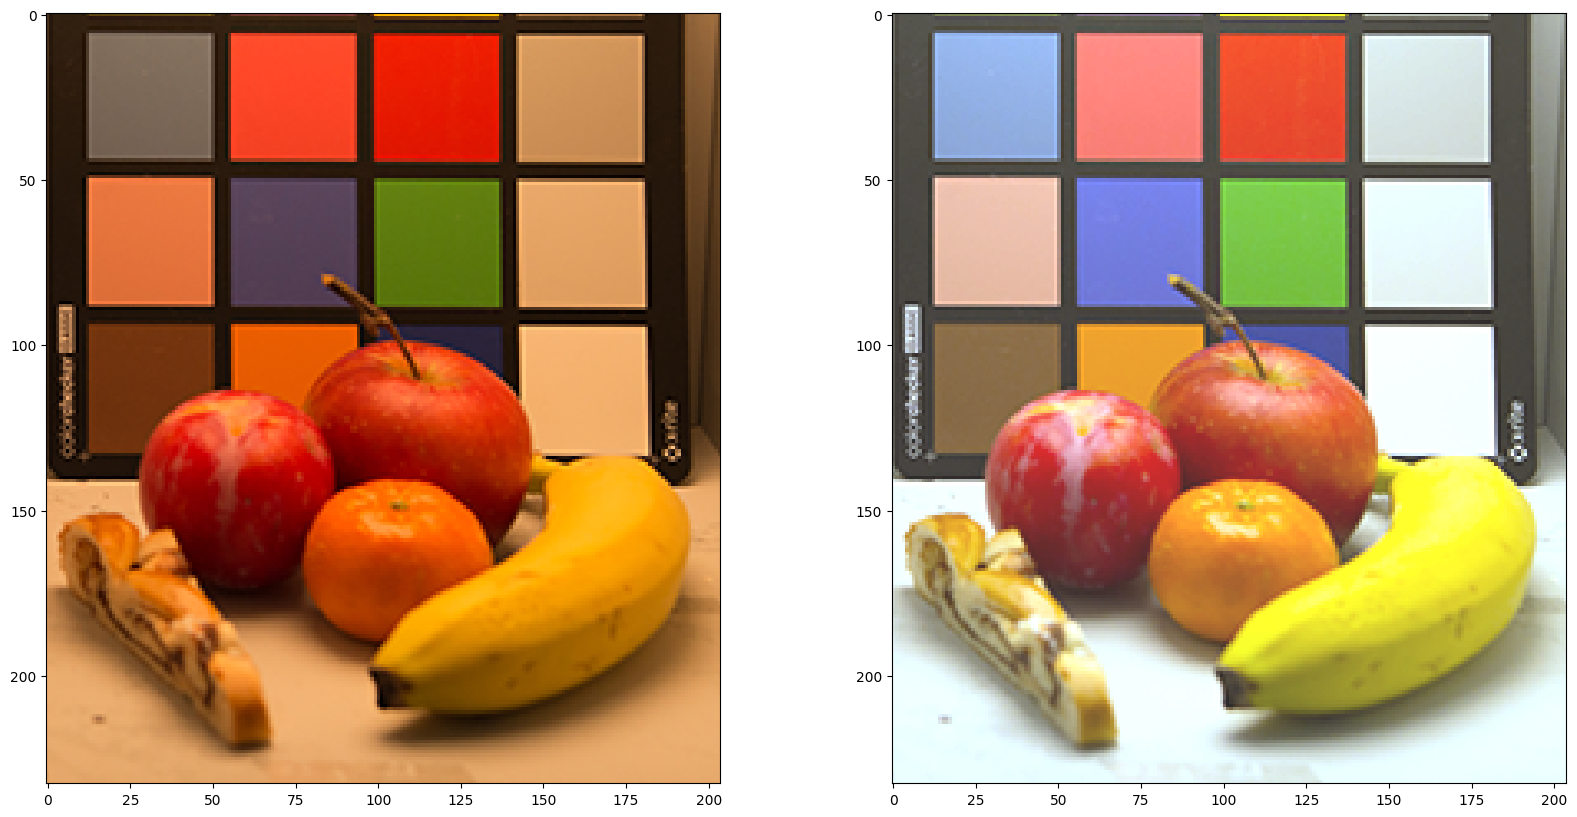

In [109]:

image = original_whole_dataset[13000][0]
dog_image = plt.imread("C:/Users/Lisa/Documents/Informatikstudium/IDP/derma_ai_idp/fruits.jpg")
dog_image = torch.from_numpy(dog_image)
dog_image_c = np.copy(dog_image)
dog_image_c = transforms.ToTensor()(dog_image_c)
print(dog_image_c.shape)

color_corrected_img = color_constancy(image)
color_corrected_dog_img = color_constancy(dog_image_c)
gamma_image = color_constancy(image, gamma= 2.2)
f, ax = plt.subplots(1, 2)

img = color_corrected_img.numpy()
img_dog = color_corrected_dog_img.numpy()
gamma_image = gamma_image.numpy()
#ax[0].imshow(np.transpose(image, (1,2,0)))
ax[0].imshow(dog_image)
#ax[0].set_title("Original image")
#ax[1].imshow(np.transpose(img, (1,2,0)))
ax[1].imshow(np.transpose(img_dog, (1,2,0)))
#ax[1].set_title("Color constancy algorithm Shades of Gray used")
#ax[2].imshow(np.transpose(gamma_image,(1,2,0)))